<a href="https://colab.research.google.com/github/mohammel-debug/hmm-pos-tagger/blob/main/Implement_an_HMM_PoS_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPLEMENTING AN HMM POS TAGGER**

GitHub Link: https://github.com/mohammel-debug/hmm-pos-tagger/tree/main

# **OUTLINE**

### 1.   Datasets loading
### 2.   Data Parsing
###3.   HMM Implementation
###4.   Evaluation
###5.   Model Improvements
###6.   Analysis and Discussion
###7.   Conclusion

# **1. Datasets Loading**

In [ ]:
import nltk
nltk.download('universal_tagset')
!pip install conllu
# dataset 1: CHILDES
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-train.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-dev.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_English-CHILDES/master/en_childes-ud-test.conllu


# dataset 2: Web Text (EWT)
# Download EWT dataset with exact filenames
!wget -O /content/en_ewt-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
!wget -O /content/en_ewt-ud-dev.conllu   https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu
!wget -O /content/en_ewt-ud-test.conllu  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


--2025-11-29 12:12:02--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15029817 (14M) [text/plain]
Saving to: ‘/content/en_ewt-ud-train.conllu’

/content/en_ewt-ud- 100%[===================>]  14.33M  --.-KB/s    in 0.1s    

2025-11-29 12:12:02 (139 MB/s) - ‘/content/en_ewt-ud-train.conllu’ saved [15029817/15029817]

--2025-11-29 12:12:02--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connect

CHILDES Dataset

In [ ]:
data_train_childes = open("/content/en_childes-ud-train.conllu", "r", encoding="utf-8").read()
data_dev_childes = open("/content/en_childes-ud-dev.conllu", "r", encoding="utf-8").read()
data_test_childes = open("/content/en_childes-ud-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_childes)))
print("There are {} sentences in the testing set.".format(len(data_test_childes)))
print("There are {} sentences in the development set.".format(len(data_dev_childes)))

There are 19558483 sentences in the training set.
There are 5194505 sentences in the testing set.
There are 2159081 sentences in the development set.


EWT Dataset

In [ ]:
data_train_ewt = open("/content/en_ewt-ud-train.conllu", "r", encoding="utf-8").read()
data_dev_ewt = open("/content/en_ewt-ud-dev.conllu", "r", encoding="utf-8").read()
data_test_ewt = open("/content/en_ewt-ud-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_ewt)))
print("There are {} sentences in the testing set.".format(len(data_test_ewt)))
print("There are {} sentences in the development set.".format(len(data_dev_ewt)))

There are 15028897 sentences in the training set.
There are 1899745 sentences in the testing set.
There are 1897963 sentences in the development set.


In [ ]:
print(data_train_childes[:500])
print("----------------------------------")
print(data_train_ewt[:500])

# sent_id = 0
# original_sent_id = 1754162
# s_24_sent_id = 14944
# child_name = Adam
# childes_toks = you won't cut your finger what
# corpus_name = Brown
# gold_annotation = False
# child_age = 41.95363354483665
# child_gender = male
# speaker_role = Investigator
# type = question
# text = You won 't cut your finger what?
1	You	you	PRON	PRP	_	4	nsubj	4:nsubj	_
2	won	will	AUX	VBD	_	4	aux	4:aux	_
3	't	not	PART	RB	_	4	advmod	4:advmod	_
4	cut	cut	VERB	VB	_	0	root	0:root	_
5	your	your	PRON	PRP$	_	6
----------------------------------
# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000
# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001
# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001
# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.
1	Al	Al	PROPN	NNP	Number=Sing	0	root	0:root	SpaceAfter=No
2	-	-	PUNCT	HYPH	_	3	pun

# **2. Data Parsing**

In [ ]:
def parse_data(file1):

  sentences = []
  pos_tags = []

  current_sent_tokens = []
  current_sent_tags = []

  lines = file1.strip().split('\n')

  for line in lines:
      line = line.strip()

      # Skip comments/metadata and empty lines
      if line.startswith("#") or not line:
          # If we have accumulated tokens for a sentence, save them now
          if current_sent_tokens:
              sentences.append(current_sent_tokens)
              pos_tags.append(current_sent_tags)
              current_sent_tokens = []
              current_sent_tags = []
          continue

      parts = line.split('\t')

      # Safety check: ensure line has enough columns
      if len(parts) < 4:
          continue

      # Skip multi-word ranges (e.g., "1-2") because the individual tokens follow
      if '-' in parts[0]:
          continue

      # Append Token (Column 1) and UPOS (Column 3)
      # Note: If you want the specific XPOS tag (e.g., PRP, VBD), change index 3 to 4
      current_sent_tokens.append(parts[1])
      current_sent_tags.append(parts[3])

  # Flush the final sentence if the file didn't end with a newline
  if current_sent_tokens:
      sentences.append(current_sent_tokens)
      pos_tags.append(current_sent_tags)

  # --- Output Results ---
  print(f"Total Sentences found: {len(sentences)}\n")
  return sentences, pos_tags


In [ ]:
# CHILDES dataset
sentences_train_childes, pos_tags_train_childes = parse_data(data_train_childes)
sentences_dev_childes, pos_tags_dev_childes = parse_data(data_dev_childes)
sentences_test_childes, pos_tags_test_childes = parse_data(data_test_childes)

# EWT dataset
sentences_train_ewt, pos_tags_train_ewt = parse_data(data_train_ewt)
sentences_dev_ewt, pos_tags_dev_ewt = parse_data(data_dev_ewt)
sentences_test_ewt, pos_tags_test_ewt = parse_data(data_test_ewt)

Total Sentences found: 34732

Total Sentences found: 3860

Total Sentences found: 9591

Total Sentences found: 12544

Total Sentences found: 2001

Total Sentences found: 2077



In [ ]:
tagged_sentences_train_childes = [list(zip(s, p)) for s, p in zip(sentences_train_childes, pos_tags_train_childes)]
tagged_sentences_test_childes = [list(zip(s, p)) for s, p in zip(sentences_test_childes, pos_tags_test_childes)]
tagged_sentences_dev_childes = [list(zip(s, p)) for s, p in zip(sentences_dev_childes, pos_tags_dev_childes)]

tagged_sentences_train_ewt = [list(zip(s, p)) for s, p in zip(sentences_train_ewt, pos_tags_train_ewt)]
tagged_sentences_test_ewt = [list(zip(s, p)) for s, p in zip(sentences_test_ewt, pos_tags_test_ewt)]
tagged_sentences_dev_ewt = [list(zip(s, p)) for s, p in zip(sentences_dev_ewt, pos_tags_dev_ewt)]

## The POS Tagset distribution for both CHILDES and EWT

Total number of tags for childes: 17
{'SCONJ', 'AUX', 'PRON', 'ADP', 'NUM', 'X', 'PART', 'PUNCT', 'NOUN', 'DET', 'CCONJ', 'SYM', 'ADJ', 'PROPN', 'ADV', 'INTJ', 'VERB'}
Total number of tags for ewt: 17
{'SCONJ', 'AUX', 'PRON', 'ADP', 'NUM', 'X', 'PUNCT', 'PART', 'NOUN', 'DET', 'CCONJ', 'SYM', 'ADJ', 'PROPN', 'ADV', 'INTJ', 'VERB'}


<Axes: xlabel='Samples', ylabel='Counts'>

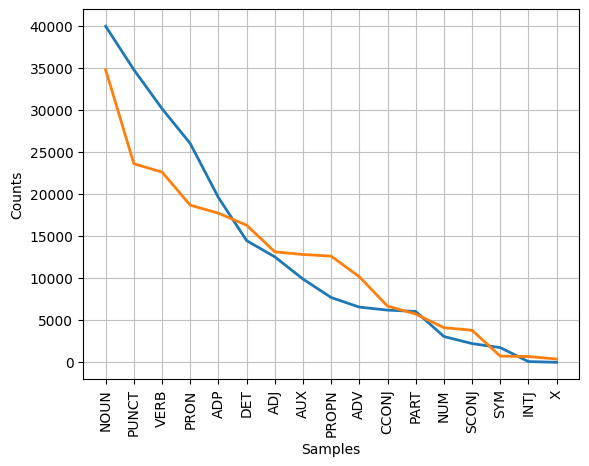

In [ ]:
tags = set()
for word_l, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags for childes: {len(tags)}")
print(tags)

tags = list()
for word, tag_l in zip(sentences_train_childes, pos_tags_train_childes):
  for tag in tag_l:
    tags.append(tag)
freq = nltk.FreqDist(tags)
freq.plot()

tags_ewt = set()
for word_l, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.add(tag)
# retrieve the total number of tags in the tagset and the set of tags
print(f"Total number of tags for ewt: {len(tags_ewt)}")
print(tags_ewt)

tags_ewt = list()
for word, tag_l in zip(sentences_train_ewt, pos_tags_train_ewt):
  for tag in tag_l:
    tags_ewt.append(tag)
freq = nltk.FreqDist(tags_ewt)
freq.plot()

# **3. HMM Implementation**

## 3.1 HMM_1

In [ ]:
from collections import defaultdict

class HMM_1:
    def __init__(self):
        self.transition = defaultdict(lambda: defaultdict(float))
        self.emission = defaultdict(lambda: defaultdict(float))
        self.start_prob = defaultdict(float)
        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()

    def train(self, train_data):
        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):
                self.vocab.add(word)
                self.tag_counts[tag] += 1
                temp_emit[tag][word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        self.states = list(self.tag_counts.keys())

        # Normalize Laplace
        total_starts = sum(temp_start.values()) + len(self.states)
        self.start_prob = {tag: (temp_start.get(tag, 0) + 1) / total_starts for tag in self.states}

        self.emission = {}
        for tag, words in temp_emit.items():
            total = sum(words.values()) + len(self.vocab)
            self.emission[tag] = {w: (words.get(w, 0) + 1) / total for w in self.vocab}

        self.transition = {}
        for prev_tag, next_tags in temp_trans.items():
            total = sum(next_tags.values()) + len(self.states)
            self.transition[prev_tag] = {t: (next_tags.get(t, 0) + 1) / total for t in self.states}

    def viterbi(self, sentence):
        V = [{}]
        path = {}

        # first word
        for state in self.states:
            emit_prob = self.emission[state].get(sentence[0], 1 / (sum(self.emission[state].values()) + len(self.vocab)))
            V[0][state] = self.start_prob.get(state, 1 / len(self.states)) * emit_prob
            path[state] = [state]

        # Recursion
        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for curr_state in self.states:
                max_prob, prev_state = max(
                    ((V[t-1][s] * self.transition.get(s, {}).get(curr_state, 1/len(self.states)) *
                      self.emission[curr_state].get(sentence[t], 1 / (sum(self.emission[curr_state].values()) + len(self.vocab))), s)
                     for s in self.states),
                    key=lambda x: x[0]
                )
                V[t][curr_state] = max_prob
                new_path[curr_state] = path[prev_state] + [curr_state]

            path = new_path

        # Termination
        n = len(sentence) - 1
        if n < 0: return []
        final_state = max((V[n][s], s) for s in self.states)[1]
        return path[final_state]

    def evaluate(self, test_data):
        total_tags = 0
        correct_tags = 0

        for sentence in test_data:
            words = [w for w, t in sentence]
            gold_tags = [t for w, t in sentence]
            pred_tags = self.viterbi(words)

            for pred, gold in zip(pred_tags, gold_tags):
                if pred == gold:
                    correct_tags += 1
                total_tags += 1

        return correct_tags / total_tags if total_tags > 0 else 0.0


### Training and Evaluating the HMM_1 on CHILDES Dataset

In [ ]:
hmm_1_childes= HMM_1()
hmm_1_childes.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_1_childes.evaluate(tagged_sentences_dev_childes))
print("CHILDES Test Accuracy:", hmm_1_childes.evaluate(tagged_sentences_test_childes))

CHILDES Dev Accuracy: 0.9191279308926368
CHILDES Test Accuracy: 0.8903310104529617


### Training and Evaluating the HMM_1 on EWT Dataset

In [ ]:
hmm_1_ewt=  HMM_1()
hmm_1_ewt.train(tagged_sentences_train_ewt)
print("EWT dev Accuracy:", hmm_1_ewt.evaluate(tagged_sentences_dev_ewt))
print("EWT Test Accuracy:", hmm_1_ewt.evaluate(tagged_sentences_test_ewt))

## 3.2 HMM_2

In [ ]:
from collections import defaultdict
import math

class HMM_2:
    def __init__(self, min_log_prob=-1e9):

        self.min_log_prob = min_log_prob
        self.transition = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.emission = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.start_prob = defaultdict(lambda: self.min_log_prob)

        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()

    def _normalize_to_log(self, d):

        total = sum(d.values())
        if total == 0: return d

        log_total = math.log(total)

        new_d = defaultdict(lambda: self.min_log_prob)

        for k, count in d.items():
            new_d[k] = math.log(count) - log_total

        return new_d

    def train(self, train_data):

        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):
                self.vocab.add(word)
                self.tag_counts[tag] += 1
                temp_emit[tag][word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        self.start_prob = self._normalize_to_log(temp_start)

        for tag in temp_emit:
            self.emission[tag] = self._normalize_to_log(temp_emit[tag])

        for prev in temp_trans:
            self.transition[prev] = self._normalize_to_log(temp_trans[prev])

        self.states = list(self.tag_counts.keys())

    def viterbi(self, sentence):
        V = [{}]
        path = {}

        for state in self.states:
            start_p = self.start_prob[state]
            emit_p = self.emission[state][sentence[0]]

            V[0][state] = start_p + emit_p
            path[state] = [state]

        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for curr_state in self.states:

                emit_p = self.emission[curr_state][sentence[t]]

                max_prob, prev_state = max(
                    (V[t - 1][y0] + self.transition[y0][curr_state] + emit_p, y0)
                    for y0 in self.states)

                V[t][curr_state] = max_prob
                new_path[curr_state] = path[prev_state] + [curr_state]

            path = new_path

        n = len(sentence) - 1
        if n < 0: return []

        prob, final_state = max((V[n][y], y) for y in self.states)
        return path[final_state]

    def evaluate(self, test_data):
        total_tags = 0
        correct_tags = 0

        for sentence in test_data:
            words = [pair[0] for pair in sentence]
            actual_tags = [pair[1] for pair in sentence]

            predicted_tags = self.viterbi(words)

            for pred, act in zip(predicted_tags, actual_tags):
                if pred == act:
                    correct_tags += 1
                total_tags += 1

        if total_tags == 0:
            return 0.0

        return correct_tags / total_tags

### Training and Evaluating the HMM_2 on CHILDES Dataset

In [ ]:
hmm_2_childes= HMM_2()
hmm_2_childes.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_2_childes.evaluate(tagged_sentences_dev_childes))
print("CHILDES Test Accuracy:", hmm_2_childes.evaluate(tagged_sentences_test_childes))

CHILDES Dev Accuracy: 0.93944878650761
CHILDES Test Accuracy: 0.9087979094076655


### Training and Evaluating the HMM_2 on EWT Dataset

In [ ]:
hmm_2_ewt= HMM_2()
hmm_2_ewt.train(tagged_sentences_train_ewt)
print("EWT dev Accuracy:", hmm_2_ewt.evaluate(tagged_sentences_dev_ewt))
print("EWT Test Accuracy:", hmm_2_ewt.evaluate(tagged_sentences_test_ewt))

EWT dev Accuracy: 0.8837421971293388
EWT Test Accuracy: 0.8856789926681543


# **4. Evaluation**

CHILDES Dev Accuracy: 0.936  VS. EWT dev Accuracy: 0.86

CHILDES Test Accuracy: 0.90  VS. EWT Test Accuracy: 0.865

This difference can be accounted for by the fact that the CHILDES dataset contains simple sentences and many words are repeated. In contrast, the EWT dataset is very diverse and can contain more larger and unknown words



We do some tests to see how the models perform:

In [ ]:
test_s = "Hello, how are you doing today, Jorge ?".split()

print("HMM_1")
print(hmm_1_childes.viterbi(test_s))
print(hmm_1_ewt.viterbi(test_s))
print("="*50)
print("HMM_2")
print(hmm_2_childes.viterbi(test_s))
print(hmm_2_ewt.viterbi(test_s))

## Error Analysis (HMM_1 vs. HMM_2)

In [ ]:
def calculate_error_rates(model, test_data):
    """
    Calculates specific error rates and counts for known vs. unknown words.
    """
    known_total = 0
    known_errors = 0
    unknown_total = 0
    unknown_errors = 0

    for sentence in test_data:
        words = [w for w, t in sentence]
        gold_tags = [t for w, t in sentence]

        try:
            pred_tags = model.viterbi(words)
        except:
            continue

        for word, pred, gold in zip(words, pred_tags, gold_tags):
            if word in model.vocab:
                known_total += 1
                if pred != gold:
                    known_errors += 1
            else:
                unknown_total += 1
                if pred != gold:
                    unknown_errors += 1

    known_error_rate = known_errors / known_total if known_total > 0 else 0
    unknown_error_rate = unknown_errors / unknown_total if unknown_total > 0 else 0

    total_ops = known_total + unknown_total
    total_errors = known_errors + unknown_errors
    total_error_rate = total_errors / total_ops if total_ops > 0 else 0

    return known_error_rate, unknown_error_rate, total_error_rate, known_errors, unknown_errors

#HMM_1
k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_1_childes, tagged_sentences_test_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_1_ewt, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (HMM_1)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

print("\n"*2)

#HMM_2
k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_2_childes, tagged_sentences_test_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_2_ewt, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (HMM_2)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

We can see that the error rate for unknown words is very high in both datasets, especially in CHILDES, suggesting that the model generalization for unknown words is worse. Given this baseline we can improve it by reducing the known word error rate, the unknown word error rate or the amount of unknown words.

In [ ]:
def find_and_print_unknowns(test_data, model, num_sentences):
    RED = "\033[91m"
    RESET = "\033[0m"

    found_count = 0

    for sentence in test_data:
        if found_count >= num_sentences:
            break

        words = [pair[0] for pair in sentence]
        actual_tags = [pair[1] for pair in sentence]

        has_unknown_word = any(word not in model.vocab for word in words)

        if has_unknown_word:
            predicted_tags = model.viterbi(words)

            formatted_words = []
            for word in words:
                if word not in model.vocab:
                    formatted_words.append(f"{RED}'{word}'{RESET}")
                else:
                    formatted_words.append(f"'{word}'")

            display_string = "[" + ", ".join(formatted_words) + "]"

            print(f"Sentence {found_count + 1} (Contains Unknowns):")
            print(f"Words:     {display_string}")
            print(f"Predicted: {predicted_tags}")
            print(f"Correct:   {actual_tags}")
            print("-" * 50)

            found_count += 1

    if found_count == 0:
        print("No sentences with unknown words were found.")

print("HMM_1 \n")
print("Childes")
find_and_print_unknowns(tagged_sentences_test_childes, hmm_2_childes, 2)
print("\n" + "="*40 + "\n")
print("EWT")
find_and_print_unknowns(tagged_sentences_test_ewt, hmm_2_ewt, 2)

print("\nHMM_2\n")
print("Childes")
find_and_print_unknowns(tagged_sentences_test_childes, hmm_2_childes, 2)
print("\n" + "="*40 + "\n")
print("EWT")
find_and_print_unknowns(tagged_sentences_test_ewt, hmm_2_ewt, 2)

# **5. Model Improvements**

## 5.1 "UNK" for Unkown Words

We will define the new class (HMM_unk)

In [ ]:
from collections import defaultdict
import math

class HMM_unk:
    def __init__(self, min_log_prob=-1e9):
        self.min_log_prob = min_log_prob
        self.transition = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.emission = defaultdict(lambda: defaultdict(lambda: self.min_log_prob))
        self.start_prob = defaultdict(lambda: self.min_log_prob)
        self.tag_counts = defaultdict(int)
        self.states = []
        self.vocab = set()
        self.unk_token = "<UNK>"

    def _normalize_to_log(self, d):
        total = sum(d.values())
        if total == 0: return d
        log_total = math.log(total)
        new_d = defaultdict(lambda: self.min_log_prob)
        for k, count in d.items():
            new_d[k] = math.log(count) - log_total
        return new_d

    def train(self, train_data, freq_threshold=1):

        word_counts = defaultdict(int)
        for sentence in train_data:
            for word, tag in sentence:
                word_counts[word] += 1


        low_freq_words = {word for word, count in word_counts.items() if count <= freq_threshold}

        self.vocab.add(self.unk_token)

        temp_start = defaultdict(int)
        temp_trans = defaultdict(lambda: defaultdict(int))
        temp_emit = defaultdict(lambda: defaultdict(int))

        for sentence in train_data:
            prev_tag = None
            for i, (word, tag) in enumerate(sentence):

                if word in low_freq_words:
                    train_word = self.unk_token
                else:
                    train_word = word
                    self.vocab.add(train_word)

                self.tag_counts[tag] += 1
                temp_emit[tag][train_word] += 1

                if i == 0:
                    temp_start[tag] += 1
                else:
                    temp_trans[prev_tag][tag] += 1
                prev_tag = tag

        # Normalize
        self.start_prob = self._normalize_to_log(temp_start)
        for tag in temp_emit:
            self.emission[tag] = self._normalize_to_log(temp_emit[tag])
        for prev in temp_trans:
            self.transition[prev] = self._normalize_to_log(temp_trans[prev])

        self.states = list(self.tag_counts.keys())

    def viterbi(self, sentence):
        V = [{}]
        path = {}

        processed_sentence = []
        for word in sentence:
            if word in self.vocab:
                processed_sentence.append(word)
            else:
                processed_sentence.append(self.unk_token)

        for state in self.states:
            start_p = self.start_prob[state]
            emit_p = self.emission[state][processed_sentence[0]]

            V[0][state] = start_p + emit_p
            path[state] = [state]

        for t in range(1, len(processed_sentence)):
            V.append({})
            new_path = {}

            for curr_state in self.states:
                emit_p = self.emission[curr_state][processed_sentence[t]]

                max_prob, prev_state = max(
                    (V[t - 1][y0] + self.transition[y0][curr_state] + emit_p, y0)
                    for y0 in self.states)

                V[t][curr_state] = max_prob
                new_path[curr_state] = path[prev_state] + [curr_state]

            path = new_path

        n = len(sentence) - 1
        if n < 0: return []
        prob, final_state = max((V[n][y], y) for y in self.states)
        return path[final_state]

    def evaluate(self, test_data):
        total_tags = 0
        correct_tags = 0
        for sentence in test_data:
            words = [pair[0] for pair in sentence]
            actual_tags = [pair[1] for pair in sentence]
            predicted_tags = self.viterbi(words)
            for pred, act in zip(predicted_tags, actual_tags):
                if pred == act: correct_tags += 1
                total_tags += 1
        if total_tags == 0: return 0.0
        return correct_tags / total_tags

### Training and Evaluating the HMM on CHILDES Dataset

In [ ]:
hmm_childes_unk= HMM_unk()
hmm_childes_unk.train(tagged_sentences_train_childes)
print("CHILDES Dev Accuracy:", hmm_childes_unk.evaluate(tagged_sentences_dev_childes))
print("CHILDES Test Accuracy:", hmm_childes_unk.evaluate(tagged_sentences_test_childes))

The test accuracy improves 1\%

### Training and Evaluating the HMM on EWT Dataset

In [ ]:
hmm_ewt_unk= HMM_unk()
hmm_ewt_unk.train(tagged_sentences_train_ewt)
print("EWT dev Accuracy:", hmm_ewt_unk.evaluate(tagged_sentences_dev_ewt))
print("EWT Test Accuracy:", hmm_ewt_unk.evaluate(tagged_sentences_test_ewt))

The test accuracy improves 1\% on both datasets

### Error Analysis

In [ ]:
k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_childes_unk, tagged_sentences_test_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_ewt_unk, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

Adding "UNK" reduces errors on unknown words and improves the overall accuracy.

### 5.1.1 HMM vs. HMM (UNK)

In [ ]:
models = [
    (hmm_childes_unk, "CHILDES (with <UNK>)"),
    (hmm_ewt_unk, "EWT (with <UNK>)"),
    (hmm_childes, "CHILDES (without <UNK>)"),
    (hmm_ewt, "EWT (without <UNK>)")
]

datasets = [
    tagged_sentences_test_childes,
    tagged_sentences_test_ewt,
    tagged_sentences_test_childes,
    tagged_sentences_test_ewt
]

print("="*50)
print("COMBINED ERROR ANALYSIS (Known vs Unknown)")
print("="*50)

for (model, name), test_data in zip(models, datasets):
    k_rate, u_rate, t_rate, k_count, u_count = calculate_error_rates(model, test_data)
    print(f"{name}:")
    print(f"  - Known Word Error Rate:   {k_rate:.2%}  (Count: {k_count})")
    print(f"  - Unknown Word Error Rate: {u_rate:.2%}  (Count: {u_count})")
    print(f"  - Total Error Rate:        {t_rate:.2%}")
    print("-"*50)


## 5.2 Larger Training Sets

### 5.2.1 Training Generalization (Scaling the training data)


We will see if training on both datasets improve the model performance on the test set of both datasets, meaning the model is capable of generalizing knowledge from another data distribution

In [ ]:
# Combine the train set of childes and ewt
tagged_sentences_train = tagged_sentences_train_childes + tagged_sentences_train_ewt

print(len(tagged_sentences_train))

# Train our best model on this combined dataset
hmm_combined = HMM_unk()
hmm_combined.train(tagged_sentences_train)


47276


We now have 47276 training sentences

In [ ]:
#Evaluate on both test sets
print("CHILDES Dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_childes))
print("CHILDES Test Accuracy:", hmm_combined.evaluate(tagged_sentences_test_childes))

print("EWT dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_ewt))
print("EWT Test Accuracy:", hmm_combined.evaluate(tagged_sentences_test_ewt))


k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_combined, tagged_sentences_test_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_combined, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

For CHILDES, we can see that even though we were not able to reduce the unknow word error rate, we reduced the known word error rate and the amount of unknown words \(now the model has seen more words because it was trained on a bigger corpus).

For EWT, the accuracy did not improve. We were able to reduce a little bit the unknown words error rate and the amount of unknown words, but the known word error rate increased, leading to a worse accuracy on the test set.

### 5.2.2 Expanding Training Data

In [ ]:
!wget -O /content/gum-test.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-test.conllu
!wget -O /content/gum-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-dev.conllu
!wget -O /content/gum-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-train.conllu

!wget -O /content/lines-test.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-LinES/refs/heads/master/en_lines-ud-test.conllu
!wget -O /content/lines-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-LinES/refs/heads/master/en_lines-ud-dev.conllu
!wget -O /content/lines-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_English-LinES/refs/heads/master/en_lines-ud-train.conllu


--2025-11-29 12:51:28--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-test.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926279 (2.8M) [text/plain]
Saving to: ‘/content/gum-test.conllu’

/content/gum-test.c 100%[===================>]   2.79M  --.-KB/s    in 0.08s   

2025-11-29 12:51:28 (37.2 MB/s) - ‘/content/gum-test.conllu’ saved [2926279/2926279]

--2025-11-29 12:51:28--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/refs/heads/master/en_gum-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... c

In [ ]:
data_train_gum = open("/content/gum-train.conllu", "r", encoding="utf-8").read()
data_dev_gum = open("/content/gum-dev.conllu", "r", encoding="utf-8").read()
data_test_gum = open("/content/gum-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_gum)))
print("There are {} sentences in the testing set.".format(len(data_test_gum)))
print("There are {} sentences in the development set.".format(len(data_dev_gum)))

print("="*50)

data_train_lines = open("/content/lines-train.conllu", "r", encoding="utf-8").read()
data_dev_lines = open("/content/lines-dev.conllu", "r", encoding="utf-8").read()
data_test_lines = open("/content/lines-test.conllu", "r", encoding="utf-8").read()

print("There are {} sentences in the training set.".format(len(data_train_lines)))
print("There are {} sentences in the testing set.".format(len(data_test_lines)))
print("There are {} sentences in the development set.".format(len(data_dev_lines)))

There are 18479256 sentences in the training set.
There are 2923892 sentences in the testing set.
There are 2922778 sentences in the development set.
There are 3862257 sentences in the training set.
There are 1193631 sentences in the testing set.
There are 1292017 sentences in the development set.


In [ ]:
sentences_train_gum, pos_tags_train_gum = parse_data(data_train_gum)
sentences_dev_gum, pos_tags_dev_gum = parse_data(data_dev_gum)
sentences_test_gum, pos_tags_test_gum = parse_data(data_test_gum)
print("="*50)
# lines dataset
sentences_train_lines, pos_tags_train_lines = parse_data(data_train_lines)
sentences_dev_lines, pos_tags_dev_lines = parse_data(data_dev_lines)
sentences_test_lines, pos_tags_test_lines = parse_data(data_test_lines)

Total Sentences found: 10224

Total Sentences found: 1575

Total Sentences found: 1464

Total Sentences found: 3457

Total Sentences found: 1118

Total Sentences found: 1121



In [ ]:
tagged_sentences_train_gum = [list(zip(s, p)) for s, p in zip(sentences_train_gum, pos_tags_train_gum)]
tagged_sentences_test_gum = [list(zip(s, p)) for s, p in zip(sentences_test_gum, pos_tags_test_gum)]
tagged_sentences_dev_gum = [list(zip(s, p)) for s, p in zip(sentences_dev_gum, pos_tags_dev_gum)]

tagged_sentences_train_lines = [list(zip(s, p)) for s, p in zip(sentences_train_lines, pos_tags_train_lines)]
tagged_sentences_test_lines = [list(zip(s, p)) for s, p in zip(sentences_test_lines, pos_tags_test_lines)]
tagged_sentences_dev_lines = [list(zip(s, p)) for s, p in zip(sentences_dev_lines, pos_tags_dev_lines)]

In [ ]:
# Combine the train set of childes and ewt
tagged_sentences_train = tagged_sentences_train_childes + tagged_sentences_train_ewt + tagged_sentences_train_gum + tagged_sentences_train_lines

print(len(tagged_sentences_train))

# Train our best model on this combined dataset
hmm_combined = HMM_unk()
hmm_combined.train(tagged_sentences_train)


60957


We increased the training set up to 60957 sentences.

In [ ]:
#Evaluate on both test sets
print("CHILDES Dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_childes))
print("CHILDES Test Accuracy:", hmm_combined.evaluate(tagged_sentences_test_childes))

print("EWT dev Accuracy:", hmm_combined.evaluate(tagged_sentences_dev_ewt))
print("EWT Test Accuracy:", hmm_combined.evaluate(tagged_sentences_test_ewt))


k_rate_childes, u_rate_childes, t_rate_childes, k_count_childes, u_count_childes = calculate_error_rates(hmm_combined, tagged_sentences_test_childes)

k_rate_ewt, u_rate_ewt, t_rate_ewt, k_count_ewt, u_count_ewt = calculate_error_rates(hmm_combined, tagged_sentences_test_ewt)

print("="*50)
print("DETAILED ERROR ANALYSIS (Rates & Volume)")
print("="*50)

print(f"CHILDES DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_childes:.2%}  (Count: {k_count_childes})")
print(f"  - Unknown Word Error Rate: {u_rate_childes:.2%}  (Count: {u_count_childes})")
print(f"  - Total Error Rate:        {t_rate_childes:.2%}")
print("-" * 50)

print(f"EWT DATASET:")
print(f"  - Known Word Error Rate:   {k_rate_ewt:.2%}  (Count: {k_count_ewt})")
print(f"  - Unknown Word Error Rate: {u_rate_ewt:.2%}  (Count: {u_count_ewt})")
print(f"  - Total Error Rate:        {t_rate_ewt:.2%}")
print("="*50)

Unfortunately, we were not able to improve the model accuracy when scaling the training data. Indeed, the performance dropped a little bit, it might be the new training data included followed a very different distribution. However, language is always the same, so increasing the amount of sentences the model sees should led to a more accurate/robust model.

# **6. Analysis and Discussion**

# **7. Conclusion**

XXXXXX  


**Key Insights:**


 **xxxx**

# We can share our ideas here

TODO

- Same method. Try with the other dataset
- Combine datasets and train.
- Test with one and the other dataset. Combined.
- Plot the accuracies. Analyse.
- How to improve.
- Analyse the error per tag, and the reason. For each model.
- Check nltk for interesting methods.
- See if we can add more things from the unfinished chunking lab.
- Trigram HMM


Yo probaria todas las mejoras: UNK, laplace smoothing, convertir syn/ant, trigram hmm, ... Y luego entrenaria sobre los dos datasets para y evaluar para ver si ver más datos ayuda al modelo a generalizar más

-Sounds good!!